# Train gesture classification model

This script contains all necessary code to train a gesture classification model based on the
MobileNet architecture. Some lines of code like paths have to be adjusted for your case.
All needed adjustments are marked with "Todo".

Before executing this script the necessary dataset called LaRED has to be loaded. A complete data preprocessing
script can be found under data_preprocessing/data_preprocessing_lared.ipynb.

In [1]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2

import csv
import pandas as pd

import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, CSVLogger, ModelCheckpoint

%matplotlib inline

In [2]:
# ToDo: Only necessary if you changed the selected gestures in the script data_preprocessing_lared.ipynb.
# adjust the names and quantity of the gestures here too.

INDEX_TO_LABEL = {
    0 :"crawl",
    1 :"fist",
    2 :"five",
    3 :"palm",
    4 :"peace",

}

# Todo: If you changed the amount of gestures in data_preprocessing_lared.ipynb change the number here too.
NUMBER_OF_CLASSES = 5
NUMBER_OF_PROBANDS_IN_TESTSET = 9

BATCH_SIZE=32

IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64

TRAINING_DIR = "C:/datasets/lared/cropped_gesture64x64/train"

### Load data

The training time is reduced considerably when loading images into memory instead of reading them from disk.

In [3]:
def images_to_array(path):
    """ This method takes a path containing images in different folders representing the classes.
    Parameters:
        path (str): path to image folder
    Returns:
        Two arrays containing the images and corresponding labels
     """
    images = []
    labels = []

    curr_label = 0
    
    # iterate over gesture folders
    for dir_gesture in os.listdir(path):
        curr_dir = os.path.join(path, dir_gesture)
        curr_files = os.listdir(curr_dir)
        
        print(dir_gesture)
        
        for file in curr_files:
            img_path = os.path.join(curr_dir, file)
            image_as_array = cv2.imread(img_path)
            image_as_array = cv2.resize(image_as_array, (IMAGE_HEIGHT,IMAGE_WIDTH))
            image_as_array = cv2.cvtColor(image_as_array, cv2.COLOR_BGR2RGB)

            images.append(image_as_array)
            # labels have to be saved in categorical format for training
            labels.append(tf.keras.utils.to_categorical(curr_label,NUMBER_OF_CLASSES))
  
        curr_label = curr_label + 1
        
    return np.array(images), labels

train_images, train_labels =  images_to_array(TRAINING_DIR)
print("Train images     ",  np.array(train_images).shape, "Train labels",  len(train_labels))

crawl
fist
five
palm
peace
Train images      (12150, 64, 64, 3) Train labels 12150


### Setup and test data augmentation

The image is being randomly flipped horizontally and rotated up to 20 degrees to recognize slightly 
rotated hands and also left hands, since the dataset contains only right-hand gestures. 
In addition, the images are being slightly and randomly shifted in width and zoomed in or 
out for the case where the detection model does not align the bounding box perfectly. 
And lastly the brightness of the input images is being randomly manipulated to allow 
to recognize gestures under challenging conditions.

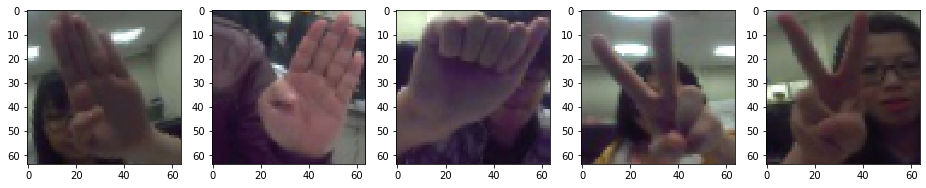

In [4]:
train_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=20,
      width_shift_range=0.1,
      zoom_range=(0.7, 1.1),
      horizontal_flip=True,
      brightness_range=(0.5,1.5),
      fill_mode='nearest',
)

# validation data is not augmented
val_datagen = ImageDataGenerator(rescale = 1./255)

# test data augmentation by plotting some example augmentations
i = 0
plt.figure(figsize=(16,16))
for batch in train_datagen.flow(np.array(train_images), batch_size=32):
    plot_position = "1"+str(NUMBER_OF_CLASSES)+str(i+1)
    plt.subplot(plot_position)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % NUMBER_OF_CLASSES == 0:
        break

plt.show()

In [5]:
def get_fold(current_fold, train_images, train_labels):
    """
    The training set is structured as follows: gesture1 [subject1, subject2 .. subject9], gesture2 [subject1, ..
    This method takes one dedicated subject for validation and the rest for training. current fold defines,
    which subject is used for validation.
    
    Parameters:
        current_fold (int): number form 0 to total number of folds 
        train_images [array]: images as array 
        train_labels [array]: labels as array 
    Returns:
         images of 8 subjects for training and 1 for validation.
    """
    
    k = NUMBER_OF_PROBANDS_IN_TESTSET
    num_samples_per_gesture = round(len(train_images)/NUMBER_OF_CLASSES)

    fold_size = round(num_samples_per_gesture/k)

    partial_train_images, val_images, partial_train_labels, val_labels = [], [], [], []
    
    # patch together all gestures by subject
    for i in range(NUMBER_OF_CLASSES):
        
        start_index = num_samples_per_gesture * i
        train_images_current_gesture = train_images[start_index:start_index+num_samples_per_gesture]
        train_labels_current_gesture = train_labels[start_index:start_index+num_samples_per_gesture]

        val_images.extend(train_images_current_gesture[current_fold*fold_size:(current_fold+1)*fold_size])
        partial_train_images.extend(train_images_current_gesture[:current_fold*fold_size])
        partial_train_images.extend(train_images_current_gesture[(current_fold+1)*fold_size:])
  
        val_labels.extend(train_labels_current_gesture[current_fold*fold_size:(current_fold+1)*fold_size])
        partial_train_labels.extend(train_labels_current_gesture[:current_fold*fold_size])
        partial_train_labels.extend(train_labels_current_gesture[(current_fold+1)*fold_size:])

    return partial_train_images, val_images, partial_train_labels, val_labels

### Test fold generation

Test if the fold has been created correctly by showing the boundaries of the fold.
We plot the last index of the fold and the first index of the ramaining subjects. There subject should differ.


10800 1350
10800 1350
first index val


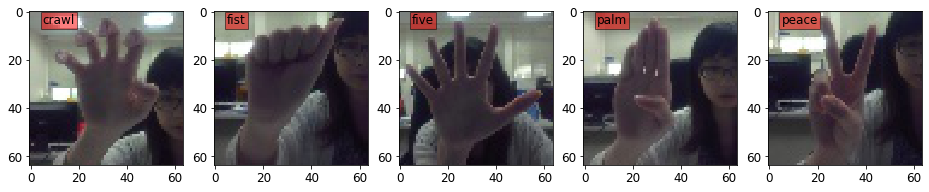

last index val


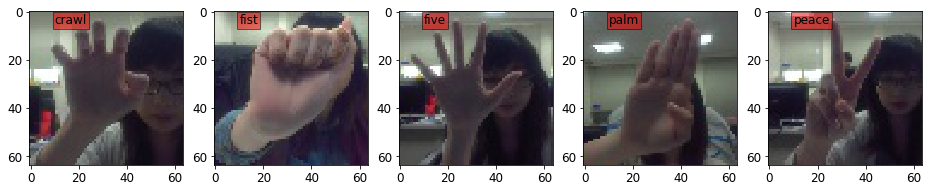

first index train


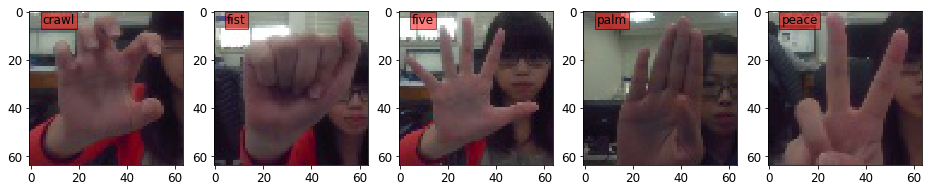

last index train


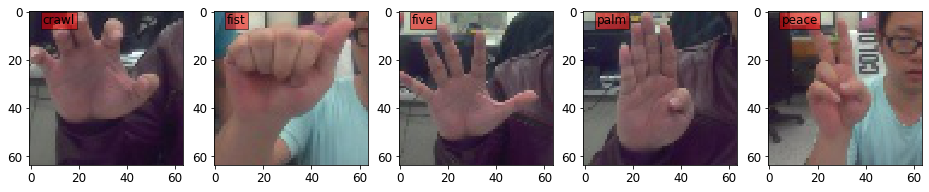

In [6]:
FOLD_TO_TEST = 0

plt.rc('font', size=12)

partial_train_images, val_images, partial_train_labels, val_labels = get_fold(FOLD_TO_TEST, train_images, train_labels)
print(len(partial_train_images), len(val_images))
print(len(partial_train_labels), len(val_labels))


plt.figure(figsize=(16,16))
number_samles_per_gesture_val = int(len(val_images)/NUMBER_OF_CLASSES)
print("first index val")
for i in range(NUMBER_OF_CLASSES):
    index = number_samles_per_gesture_val * i
    plot_position = "1"+str(NUMBER_OF_CLASSES)+str(i+1)
    plt.subplot(plot_position)
    text = INDEX_TO_LABEL[np.argmax(val_labels[index])]
    plt.text(5,5,text, bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 2})
    plt.imshow(val_images[index])
plt.show()


plt.figure(figsize=(16,16))
print("last index val")
for i in range(NUMBER_OF_CLASSES):
    index = number_samles_per_gesture_val * i + number_samles_per_gesture_val-1
    plot_position = "1"+str(NUMBER_OF_CLASSES)+str(i+1)
    
    plt.subplot(plot_position)
    text = INDEX_TO_LABEL[np.argmax(val_labels[index])]
    plt.text(10,5,text, bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 2})
    plt.imshow(val_images[index])

plt.show()

number_samles_per_gesture_train = int(len(partial_train_images)/NUMBER_OF_CLASSES)
plt.figure(figsize=(16,16))
print("first index train")
for i in range(NUMBER_OF_CLASSES):
    index = number_samles_per_gesture_train * i
    plot_position = "1"+str(NUMBER_OF_CLASSES)+str(i+1)
    
    plt.subplot(plot_position)
    text = INDEX_TO_LABEL[np.argmax(partial_train_labels[index])]
    plt.text(5,5,text, bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 2})
    plt.imshow(partial_train_images[index])

plt.show()

plt.figure(figsize=(16,16))
print("last index train")
for i in range(NUMBER_OF_CLASSES):
    index = number_samles_per_gesture_train * i + number_samles_per_gesture_train-1
    plot_position = "1"+str(NUMBER_OF_CLASSES)+str(i+1)
    
    plt.subplot(plot_position)
    text = INDEX_TO_LABEL[np.argmax(partial_train_labels[index])]
    plt.text(5,5,text, bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 2})
    plt.imshow(partial_train_images[index])

plt.show()

### Load the model


In [7]:
def get_model():

    model = tf.keras.applications.MobileNet(include_top=True, 
                                            input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3),
                                            weights=None, # there are no weights available for input size 64x64
                                            classes=NUMBER_OF_CLASSES,
                                            dropout=0.5,
                                            # loads the mobilenet_0.50_64 with only 0.8M params, instead 4.2M
                                            alpha=0.5,
                                            )

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

model = get_model()
model.summary()

Model: "mobilenet_0.50_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 65, 65, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 16)        432       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 16)        64        
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 16)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 16)        144       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 16)  

### Define callbacks
ReduceLROnPlateau: 
The learning rate is beeing reduces when the validation loss does not imporove for a defined number uf epochs.

CSVLogger:
During training the folds the metrics "epoch,accuracy,loss,val_accuracy,val_loss" are beeng logged
to a csv file. Those metrics are used to define the best hyperparameters for the final trainng run.

Todo: If you start the training on your own, delete the previously generated log file "mobilenet_training_log.csv".

In [8]:
def get_callbacks():
    rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, verbose=1, patience=33)

    csv_logger = CSVLogger(filename='mobilenet_training_log.csv',
                           separator=',',
                           append=True)
    
    return [csv_logger, rlrop]

### Start K-Fold training

The training set was split into 9 partitions/folds, since there are 9 subjects in the training set. 
This allows to train on images from 8 subjects and validating on the remaining one, 
which wasn't  used during training. 
In each fold the a new untrained model is loaded and trained and valildated on another training subset.

In [9]:
k = NUMBER_OF_PROBANDS_IN_TESTSET

for i in range(k):
    print("processing fold #", i)
    partial_train_images, val_images, partial_train_labels, val_labels = get_fold(i, train_images, train_labels)

    train_generator = train_datagen.flow(np.array(partial_train_images), 
                                         partial_train_labels, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=True,)
    val_generator   = val_datagen.flow(np.array(val_images),           
                                       val_labels,   
                                       batch_size=BATCH_SIZE, 
                                       shuffle=False,)

    model = get_model()
    
    model.fit_generator(train_generator,
                        epochs=100, # validation accuracy does not improve after 100 epochs
                        validation_data = val_generator,
                        verbose = 1,
                        workers=2, # allows the loading of images in two parallel processes
                        callbacks=get_callbacks())
    


processing fold # 0
Epoch 1/100
338/338 [==============================] - 56s 166ms/step - loss: 1.5616 - accuracy: 0.3327 - val_loss: 1.7542 - val_accuracy: 0.2000
Epoch 2/100
338/338 [==============================] - 52s 153ms/step - loss: 0.9730 - accuracy: 0.6105 - val_loss: 1.9121 - val_accuracy: 0.2881
Epoch 3/100
338/338 [==============================] - 51s 150ms/step - loss: 0.5979 - accuracy: 0.7809 - val_loss: 1.1986 - val_accuracy: 0.5437
Epoch 4/100
338/338 [==============================] - 51s 151ms/step - loss: 0.4098 - accuracy: 0.8544 - val_loss: 1.0391 - val_accuracy: 0.6252
Epoch 5/100
338/338 [==============================] - 50s 149ms/step - loss: 0.2840 - accuracy: 0.8976 - val_loss: 1.6259 - val_accuracy: 0.5267
Epoch 6/100
338/338 [==============================] - 50s 148ms/step - loss: 0.2142 - accuracy: 0.9260 - val_loss: 1.6729 - val_accuracy: 0.5259
Epoch 7/100
338/338 [==============================] - 50s 147ms/step - loss: 0.1666 - accuracy: 0.9427 

Epoch 12/100
338/338 [==============================] - 51s 150ms/step - loss: 0.0735 - accuracy: 0.9767 - val_loss: 0.1689 - val_accuracy: 0.9593
Epoch 13/100
338/338 [==============================] - 50s 149ms/step - loss: 0.0671 - accuracy: 0.9786 - val_loss: 0.5418 - val_accuracy: 0.8689
Epoch 14/100
338/338 [==============================] - 50s 148ms/step - loss: 0.0608 - accuracy: 0.9816 - val_loss: 0.3391 - val_accuracy: 0.9126
Epoch 15/100
338/338 [==============================] - 51s 150ms/step - loss: 0.0547 - accuracy: 0.9840 - val_loss: 0.6088 - val_accuracy: 0.8533
Epoch 16/100
338/338 [==============================] - 51s 151ms/step - loss: 0.0587 - accuracy: 0.9823 - val_loss: 0.8425 - val_accuracy: 0.7704
Epoch 17/100
338/338 [==============================] - 50s 149ms/step - loss: 0.0577 - accuracy: 0.9818 - val_loss: 0.2673 - val_accuracy: 0.9178
Epoch 18/100
338/338 [==============================] - 50s 148ms/step - loss: 0.0475 - accuracy: 0.9846 - val_loss: 0

Epoch 68/100
338/338 [==============================] - 51s 150ms/step - loss: 0.0056 - accuracy: 0.9989 - val_loss: 0.0609 - val_accuracy: 0.9770
Epoch 69/100
338/338 [==============================] - 50s 147ms/step - loss: 0.0066 - accuracy: 0.9983 - val_loss: 4.7393 - val_accuracy: 0.6570
Epoch 70/100
338/338 [==============================] - 50s 148ms/step - loss: 0.0086 - accuracy: 0.9977 - val_loss: 0.0850 - val_accuracy: 0.9778
Epoch 71/100
338/338 [==============================] - 50s 149ms/step - loss: 0.0075 - accuracy: 0.9983 - val_loss: 0.1297 - val_accuracy: 0.9637
Epoch 72/100
338/338 [==============================] - 51s 150ms/step - loss: 0.0093 - accuracy: 0.9971 - val_loss: 0.1391 - val_accuracy: 0.9778
Epoch 73/100
338/338 [==============================] - 50s 147ms/step - loss: 0.0050 - accuracy: 0.9987 - val_loss: 0.0929 - val_accuracy: 0.9815
Epoch 74/100
338/338 [==============================] - 50s 147ms/step - loss: 0.0058 - accuracy: 0.9980 - val_loss: 0

Epoch 78/100
338/338 [==============================] - 50s 149ms/step - loss: 0.0115 - accuracy: 0.9972 - val_loss: 0.6122 - val_accuracy: 0.8459
Epoch 79/100
338/338 [==============================] - 51s 150ms/step - loss: 0.0152 - accuracy: 0.9961 - val_loss: 0.9002 - val_accuracy: 0.8289
Epoch 80/100
338/338 [==============================] - 50s 147ms/step - loss: 0.0039 - accuracy: 0.9989 - val_loss: 0.3475 - val_accuracy: 0.9215
Epoch 81/100
338/338 [==============================] - 50s 147ms/step - loss: 0.0057 - accuracy: 0.9985 - val_loss: 0.3466 - val_accuracy: 0.9274
Epoch 82/100
337/338 [============================>.] - ETA: 0s - loss: 0.0035 - accuracy: 0.9992
Epoch 00082: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
338/338 [==============================] - 50s 149ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 1.2878 - val_accuracy: 0.7881
Epoch 83/100
338/338 [==============================] - 50s 149ms/step - loss: 0.0066 - accuracy: 0

Epoch 88/100
338/338 [==============================] - 50s 147ms/step - loss: 0.0076 - accuracy: 0.9977 - val_loss: 0.0034 - val_accuracy: 0.9993
Epoch 89/100
338/338 [==============================] - 50s 147ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 0.0494 - val_accuracy: 0.9896
Epoch 90/100
338/338 [==============================] - 50s 149ms/step - loss: 0.0128 - accuracy: 0.9969 - val_loss: 0.0050 - val_accuracy: 0.9985
Epoch 91/100
338/338 [==============================] - 51s 150ms/step - loss: 0.0055 - accuracy: 0.9981 - val_loss: 8.1379e-04 - val_accuracy: 0.9993
Epoch 92/100
338/338 [==============================] - 51s 150ms/step - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.0045 - val_accuracy: 0.9978
Epoch 93/100
338/338 [==============================] - 50s 147ms/step - loss: 0.0110 - accuracy: 0.9974 - val_loss: 0.0113 - val_accuracy: 0.9978
Epoch 94/100
338/338 [==============================] - 50s 147ms/step - loss: 0.0089 - accuracy: 0.9972 - val_los

338/338 [==============================] - 51s 150ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 0.0342 - val_accuracy: 0.9889
Epoch 99/100
337/338 [============================>.] - ETA: 0s - loss: 8.3241e-04 - accuracy: 0.9998
Epoch 00099: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
338/338 [==============================] - 50s 148ms/step - loss: 8.3433e-04 - accuracy: 0.9998 - val_loss: 0.0087 - val_accuracy: 0.9970
Epoch 100/100
338/338 [==============================] - 50s 147ms/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.0211 - val_accuracy: 0.9941
processing fold # 5
Epoch 1/100
338/338 [==============================] - 51s 151ms/step - loss: 1.6860 - accuracy: 0.2698 - val_loss: 1.6598 - val_accuracy: 0.2000
Epoch 2/100
338/338 [==============================] - 50s 147ms/step - loss: 1.2928 - accuracy: 0.4481 - val_loss: 1.1524 - val_accuracy: 0.4526
Epoch 3/100
338/338 [==============================] - 51s 150ms/step - loss: 0.9221 

338/338 [==============================] - 51s 150ms/step - loss: 0.2253 - accuracy: 0.9234 - val_loss: 1.0303 - val_accuracy: 0.7356
Epoch 7/100
338/338 [==============================] - 50s 148ms/step - loss: 0.1696 - accuracy: 0.9429 - val_loss: 0.7573 - val_accuracy: 0.7333
Epoch 8/100
338/338 [==============================] - 50s 148ms/step - loss: 0.1439 - accuracy: 0.9544 - val_loss: 1.0213 - val_accuracy: 0.6600
Epoch 9/100
338/338 [==============================] - 51s 150ms/step - loss: 0.1260 - accuracy: 0.9592 - val_loss: 0.5940 - val_accuracy: 0.7519
Epoch 10/100
338/338 [==============================] - 51s 150ms/step - loss: 0.0987 - accuracy: 0.9679 - val_loss: 0.4106 - val_accuracy: 0.8570
Epoch 11/100
338/338 [==============================] - 50s 148ms/step - loss: 0.0783 - accuracy: 0.9743 - val_loss: 0.3535 - val_accuracy: 0.8800
Epoch 12/100
338/338 [==============================] - 50s 147ms/step - loss: 0.0714 - accuracy: 0.9776 - val_loss: 0.2439 - val_accu

Epoch 62/100
338/338 [==============================] - 51s 150ms/step - loss: 0.0112 - accuracy: 0.9973 - val_loss: 0.0162 - val_accuracy: 0.9926
Epoch 63/100
338/338 [==============================] - 50s 148ms/step - loss: 0.0125 - accuracy: 0.9971 - val_loss: 0.0170 - val_accuracy: 0.9911
Epoch 64/100
338/338 [==============================] - 50s 148ms/step - loss: 0.0060 - accuracy: 0.9979 - val_loss: 0.9248 - val_accuracy: 0.8630
Epoch 65/100
338/338 [==============================] - 51s 150ms/step - loss: 0.0089 - accuracy: 0.9971 - val_loss: 0.1546 - val_accuracy: 0.9704
Epoch 66/100
338/338 [==============================] - 51s 150ms/step - loss: 0.0083 - accuracy: 0.9975 - val_loss: 0.1039 - val_accuracy: 0.9778
Epoch 67/100
338/338 [==============================] - 50s 148ms/step - loss: 0.0107 - accuracy: 0.9970 - val_loss: 0.0386 - val_accuracy: 0.9844
Epoch 68/100
338/338 [==============================] - 50s 148ms/step - loss: 0.0101 - accuracy: 0.9970 - val_loss: 0

338/338 [==============================] - 51s 150ms/step - loss: 0.0639 - accuracy: 0.9801 - val_loss: 0.0869 - val_accuracy: 0.9652
Epoch 17/100
338/338 [==============================] - 50s 148ms/step - loss: 0.0532 - accuracy: 0.9841 - val_loss: 0.3833 - val_accuracy: 0.9215
Epoch 18/100
338/338 [==============================] - 50s 148ms/step - loss: 0.0418 - accuracy: 0.9873 - val_loss: 0.1665 - val_accuracy: 0.9437
Epoch 19/100
338/338 [==============================] - 51s 149ms/step - loss: 0.0464 - accuracy: 0.9856 - val_loss: 0.1656 - val_accuracy: 0.9496
Epoch 20/100
338/338 [==============================] - 51s 150ms/step - loss: 0.0442 - accuracy: 0.9862 - val_loss: 0.7375 - val_accuracy: 0.8763
Epoch 21/100
338/338 [==============================] - 50s 148ms/step - loss: 0.0388 - accuracy: 0.9884 - val_loss: 0.1563 - val_accuracy: 0.9437
Epoch 22/100
338/338 [==============================] - 50s 148ms/step - loss: 0.0315 - accuracy: 0.9897 - val_loss: 0.2605 - val_a

Epoch 72/100
338/338 [==============================] - 51s 150ms/step - loss: 0.0109 - accuracy: 0.9969 - val_loss: 0.0237 - val_accuracy: 0.9933
Epoch 73/100
338/338 [==============================] - 51s 150ms/step - loss: 0.0089 - accuracy: 0.9977 - val_loss: 0.0124 - val_accuracy: 0.9941
Epoch 74/100
338/338 [==============================] - 50s 147ms/step - loss: 0.0062 - accuracy: 0.9986 - val_loss: 0.0165 - val_accuracy: 0.9933
Epoch 75/100
338/338 [==============================] - 50s 147ms/step - loss: 0.0082 - accuracy: 0.9974 - val_loss: 0.0041 - val_accuracy: 0.9993
Epoch 76/100
338/338 [==============================] - 51s 150ms/step - loss: 0.0053 - accuracy: 0.9981 - val_loss: 0.0139 - val_accuracy: 0.9941
Epoch 77/100
338/338 [==============================] - 51s 150ms/step - loss: 0.0087 - accuracy: 0.9974 - val_loss: 0.0318 - val_accuracy: 0.9941
Epoch 78/100
338/338 [==============================] - 50s 147ms/step - loss: 0.0080 - accuracy: 0.9976 - val_loss: 0

338/338 [==============================] - 51s 150ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.3319 - val_accuracy: 0.8696
Epoch 81/100
338/338 [==============================] - 51s 150ms/step - loss: 9.6770e-04 - accuracy: 0.9997 - val_loss: 0.3540 - val_accuracy: 0.8659
Epoch 82/100
338/338 [==============================] - 50s 148ms/step - loss: 0.0010 - accuracy: 0.9996 - val_loss: 0.3470 - val_accuracy: 0.8644
Epoch 83/100
338/338 [==============================] - 50s 147ms/step - loss: 4.3592e-04 - accuracy: 0.9998 - val_loss: 0.3209 - val_accuracy: 0.8815
Epoch 84/100
338/338 [==============================] - 51s 150ms/step - loss: 1.8530e-04 - accuracy: 1.0000 - val_loss: 0.3204 - val_accuracy: 0.8815
Epoch 85/100
338/338 [==============================] - 51s 150ms/step - loss: 4.1253e-04 - accuracy: 0.9999 - val_loss: 0.3165 - val_accuracy: 0.8704
Epoch 86/100
338/338 [==============================] - 50s 148ms/step - loss: 1.7859e-04 - accuracy: 0.9999 - val_

### Select best hyper parameters after k-fold training

The validation and training accuracy of each fold has been saved to the 'mobilenet_training_log.csv' file.
Here this data is being loaded and evaluated. The average of the results from all folds is being calculated and plotted.
1) The best validation accuracy is calculated and printed.
2) Average training and validation over all epochs is plotted.
3) For better visualization the average training and validation over all epochs after the 50th epoch is plotted.


Best average val_accuracy: 
     epoch  accuracy      loss  val_accuracy  val_loss
67     67  0.997912  0.007794      0.975638   0.07602
Average training and validation accuracy over all epochs.


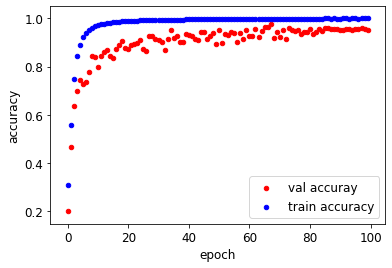

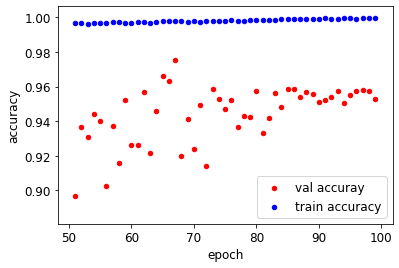

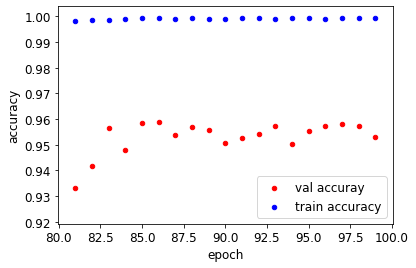

In [10]:
def read_csv(filename):
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        return list(reader)
    
history_all = pd.read_csv('mobilenet_training_log.csv')
history_mean = history_all.groupby(['epoch']).mean().reset_index()
history_mean_over50 = history_mean[history_mean['epoch'] > 50]
history_mean_over80 = history_mean[history_mean['epoch'] > 80]

best_val_accuracy = history_mean[history_mean['val_accuracy']==history_mean['val_accuracy'].max()]
print("Best average val_accuracy: \n", best_val_accuracy)

print("Average training and validation accuracy over all epochs.")
ax = plt.gca()
history_mean.plot(kind='scatter', x='epoch',y='val_accuracy',color='red', ax=ax, label="val accuray")
history_mean.plot(kind='scatter', x='epoch',y='accuracy',color='blue', ax=ax, label="train accuracy")
plt.show()

print("")
ax = plt.gca()
history_mean_over50.plot(kind='scatter', x='epoch',y='val_accuracy',color='red', ax=ax, label="val accuray")
history_mean_over50.plot(kind='scatter', x='epoch',y='accuracy',color='blue', ax=ax, label="train accuracy")
plt.show()


print("")
ax = plt.gca()
history_mean_over80.plot(kind='scatter', x='epoch',y='val_accuracy',color='red', ax=ax, label="val accuray")
history_mean_over80.plot(kind='scatter', x='epoch',y='accuracy',color='blue', ax=ax, label="train accuracy")
plt.show()


To select the best learning rate and especially the learning rate decay all occurred learning rate reduces on plateau
are recorded in the DataFrame below. This data has been collected manually from the training progress printed in the 
notebook during k-fold training.

The average epoch for the first and second reduce are printed and plotted.

   time_reduced   fold  epoch_reduced
0             1  3.875         86.875
1             2  5.000         82.000


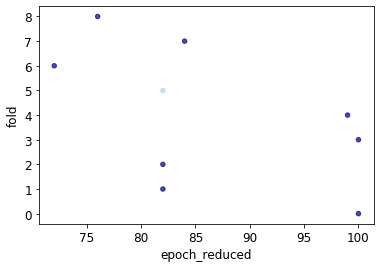

In [11]:
learning_rate = pd.DataFrame([
                   [0, 100, 1], 
                   [1, 82, 1], 
                   [2, 82, 1],
                   [3, 100, 1],  
                   [4, 99, 1], 
                   [5, 82, 2],
                   [6, 72, 1],
                   [7, 84, 1],
                   [8, 76, 1],
                  ],
                  columns=['fold', 'epoch_reduced', 'time_reduced'])

cmap = {1: 'DarkBlue', 2: 'LightBlue'}

ax1 = learning_rate.plot.scatter(x='epoch_reduced',
                      y='fold',
                      alpha=0.70,
                      color=[cmap.get(c) for c in learning_rate.time_reduced])


learning_rate_mean = learning_rate.groupby(['time_reduced']).mean().reset_index()
print(learning_rate_mean)

### Final training run

Here the final model is being trained on all training data using the best hyper parameters according to the k-fold
training.
In our case the best average validaton accuracy occurred in epoch 67. The average learning rate reduce has occured
later then in epoch 67. Therefore, no learning rate reduce on schedule is applied. A fixes learning rate is kept during
training.
For test purposes a modelCheckpoint is saved every 10 epochs. Those checkpoints are not used for the final model and
can be deleted.

In [12]:
model_checkpoint = ModelCheckpoint(filepath='mobilenet_epoch-{epoch:02d}_loss-{loss:.5f}.h5',
                                    verbose=1,
                                    save_best_only=False,
                                    save_weights_only=False
                                  )
    

train_generator = train_datagen.flow(np.array(train_images),
                                     train_labels, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True,)

model = get_model()

history = model.fit_generator(train_generator, 
                              epochs=86,
                              verbose = 1,
                              workers=2,
                              callbacks=[model_checkpoint]
                             )


Epoch 1/86
379/380 [============================>.] - ETA: 0s - loss: 1.5777 - accuracy: 0.3189
Epoch 00001: saving model to mobilenet_epoch-01_loss-1.57632.h5
380/380 [==============================] - 58s 153ms/step - loss: 1.5764 - accuracy: 0.3193
Epoch 2/86
379/380 [============================>.] - ETA: 0s - loss: 0.9179 - accuracy: 0.6413
Epoch 00002: saving model to mobilenet_epoch-02_loss-0.91610.h5
380/380 [==============================] - 58s 153ms/step - loss: 0.9164 - accuracy: 0.6418
Epoch 3/86
379/380 [============================>.] - ETA: 0s - loss: 0.5029 - accuracy: 0.8190
Epoch 00003: saving model to mobilenet_epoch-03_loss-0.50264.h5
380/380 [==============================] - 57s 150ms/step - loss: 0.5026 - accuracy: 0.8192
Epoch 4/86
379/380 [============================>.] - ETA: 0s - loss: 0.3186 - accuracy: 0.8910
Epoch 00004: saving model to mobilenet_epoch-04_loss-0.31825.h5
380/380 [==============================] - 58s 153ms/step - loss: 0.3183 - accuracy:

380/380 [==============================] - 59s 154ms/step - loss: 0.0201 - accuracy: 0.9938
Epoch 34/86
379/380 [============================>.] - ETA: 0s - loss: 0.0194 - accuracy: 0.9949
Epoch 00034: saving model to mobilenet_epoch-34_loss-0.01940.h5
380/380 [==============================] - 59s 155ms/step - loss: 0.0194 - accuracy: 0.9949
Epoch 35/86
379/380 [============================>.] - ETA: 0s - loss: 0.0190 - accuracy: 0.9946
Epoch 00035: saving model to mobilenet_epoch-35_loss-0.01895.h5
380/380 [==============================] - 54s 141ms/step - loss: 0.0189 - accuracy: 0.9947
Epoch 36/86
379/380 [============================>.] - ETA: 0s - loss: 0.0205 - accuracy: 0.9953
Epoch 00036: saving model to mobilenet_epoch-36_loss-0.02051.h5
380/380 [==============================] - 56s 146ms/step - loss: 0.0205 - accuracy: 0.9953
Epoch 37/86
379/380 [============================>.] - ETA: 0s - loss: 0.0163 - accuracy: 0.9954
Epoch 00037: saving model to mobilenet_epoch-37_loss

379/380 [============================>.] - ETA: 0s - loss: 0.0072 - accuracy: 0.9978
Epoch 00066: saving model to mobilenet_epoch-66_loss-0.00716.h5
380/380 [==============================] - 56s 148ms/step - loss: 0.0072 - accuracy: 0.9978
Epoch 67/86
379/380 [============================>.] - ETA: 0s - loss: 0.0106 - accuracy: 0.9973
Epoch 00067: saving model to mobilenet_epoch-67_loss-0.01064.h5
380/380 [==============================] - 52s 136ms/step - loss: 0.0106 - accuracy: 0.9973
Epoch 68/86
379/380 [============================>.] - ETA: 0s - loss: 0.0073 - accuracy: 0.9981
Epoch 00068: saving model to mobilenet_epoch-68_loss-0.00728.h5
380/380 [==============================] - 52s 137ms/step - loss: 0.0073 - accuracy: 0.9981
Epoch 69/86
379/380 [============================>.] - ETA: 0s - loss: 0.0067 - accuracy: 0.9981
Epoch 00069: saving model to mobilenet_epoch-69_loss-0.00673.h5
380/380 [==============================] - 53s 138ms/step - loss: 0.0067 - accuracy: 0.9981


### Save the model

The final model is being saved in tensorflow format for inference.
Optionnaly the model can be also saved in Keras format.

In [13]:
# Save in tensorflow format
model.save('model_mobilenet', save_format='tf')

# Save in keras format
# model.save('model_mobilenet', )

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_mobilenet\assets
